### Custom ML model to identify local similarities ("links") with sequence profiles

Let $$X \in \{0,1\}^{B\times N\times 6 \times T \times 21}$$ be a batch of **one-hot encoded input translated sequences**,
where $B$ is `batch_size`, $N$ is the number of genomes and $T$ is the `tile_size` (in aa).
The 6 is here the number of translated frames in order (0,+),(1,+),(2,+),(0,-),(1,-),(2,-).
The 21 is here the size of the considered amino acid alphabet.


In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import tensorflow as tf
import logomaker
from time import time
from tqdm import tqdm
from IPython.display import Audio

import importlib
import sequtils as su
print(importlib.reload(su))
import seq
print(importlib.reload(seq))
import dataset as dsg
print(importlib.reload(dsg))
import model
print(importlib.reload(model))

print(tf.__version__)

%load_ext memory_profiler

<module 'sequtils' from '/nas-hs/users/matthis/genomegraph/learn_specific_profiles/sequtils.py'>
<module 'seq' from '/nas-hs/users/matthis/genomegraph/learn_specific_profiles/seq.py'>
<module 'dataset' from '/nas-hs/users/matthis/genomegraph/learn_specific_profiles/dataset.py'>
<module 'model' from '/nas-hs/users/matthis/genomegraph/learn_specific_profiles/model.py'>
2.3.1


In [2]:
use_real_data = True

### Create random genomes as toy data 

In [3]:
N = 8            # number of genomes
tile_size = 334  # tile size measured in amino acids
# A tile is a consecutive subsequence of _one_ contig/scaffold/chromosome.
# Tiles should be about gene-sized.

#genome_sizes = [[210,100], [30,220,150], [230,110,120,90], [180]] # in nucleotides
#insertPatterns = ["ATGATGATG", "CCCCCCCCCCCC"]
#genomes = seq.getRandomGenomes(N, genome_sizes, insertPatterns, mutationProb=0.2, verbose=True)

genome_sizes = [[10000]] * N
                # in nucleotides
insertPatterns = ["ATGGCAAGAATTCAATCTACTGCAAATAAAGAA",
                 ] 
repeatPatterns = ['AGAGAACCTGAAGCTACTGCTGAACCTGAAAGA']
genomes, repeatTracking, insertTracking = seq.getRandomGenomes(N, genome_sizes, insertPatterns,
                                                               repeatPatterns,
                                                               mutationProb=0.0, 
                                                               repeatMultiple=range(0,1),
                                                               repeatInsert=range(10,11),
                                                               verbose=False)
print(insertTracking)

{0: {0: {'pos': [9467], 'pattern': ['ATGGCAAGAATTCAATCTACTGCAAATAAAGAA']}}, 1: {0: {'pos': [801], 'pattern': ['ATGGCAAGAATTCAATCTACTGCAAATAAAGAA']}}, 2: {0: {'pos': [267], 'pattern': ['ATGGCAAGAATTCAATCTACTGCAAATAAAGAA']}}, 3: {0: {'pos': [1004], 'pattern': ['ATGGCAAGAATTCAATCTACTGCAAATAAAGAA']}}, 4: {0: {'pos': [6239], 'pattern': ['ATGGCAAGAATTCAATCTACTGCAAATAAAGAA']}}, 5: {0: {'pos': [1286], 'pattern': ['ATGGCAAGAATTCAATCTACTGCAAATAAAGAA']}}, 6: {0: {'pos': [3064], 'pattern': ['ATGGCAAGAATTCAATCTACTGCAAATAAAGAA']}}, 7: {0: {'pos': [6319], 'pattern': ['ATGGCAAGAATTCAATCTACTGCAAATAAAGAA']}}}


In [4]:
def printExpectedPatterns():
    desiredPatternAA, repeatPatternAA = None, None
    if insertPatterns is not None:
        desiredPatternAA = []
        for pattern in insertPatterns:
            desiredPatternAA.extend(su.six_frame_translation(pattern))

        print("Desired:", desiredPatternAA)

    if repeatPatterns is not None:
        repeatPatternAA = []
        for pattern in repeatPatterns:
            repeatPatternAA.extend(su.six_frame_translation(pattern))

        print("Repeat:", repeatPatternAA)
        
    return desiredPatternAA, repeatPatternAA

desiredPatternAA, repeatPatternAA = printExpectedPatterns()

Desired: ['MARIQSTANKE', 'WQEFNLLQIK', 'GKNSIYCK*R', 'FFICSRLNSCH', 'SLFAVD*ILA', 'LYLQ*IEFLP']
Repeat: ['REPEATAEPER', 'ENLKLLLNLK', 'RT*SYC*T*K', 'SFRFSSSFRFS', 'LSGSAVASGS', 'FQVQQ*LQVL']


---

#### Interlude: Magic Commands

https://towardsdatascience.com/speed-up-jupyter-notebooks-20716cbe2025

`%time command` prints runtime of command  
`%prun command` profiler for command, what steps take how much time? Adds overhead  
`%memit command` peak memory usage and memory increment  
`%mprun command` memory profiling

---

In [5]:
# Load Real Data
if use_real_data:
    from Bio import SeqIO
    import os
    
    files = ['hg38.fa', 'mm10.fa', 'hetGla2.fa', 'macFas5.fa']
    genomes = [[] for _ in range(len(files))]
    seqnames = [[] for _ in range(len(files))]
    datapath = "/nas-hs_new/projs/seedFinding/data/20210517_flanked/subset"
    def loadRealGenomes(genomes=genomes):
        for i in range(len(files)):
            genomes[i].extend([str(seq.seq) for seq in SeqIO.parse(os.path.join(datapath, files[i]), 'fasta')])
            seqnames[i].extend([str(seq.id) for seq in SeqIO.parse(os.path.join(datapath, files[i]), 'fasta')])
            
    %memit loadRealGenomes()
    
    # load pickled Q to safe time
    Qfile = os.path.join(datapath, "backgroundAAFreqs.pkl4")
    if not os.path.isfile(Qfile):
        print("Getting Q")
        %time Q = seq.backGroundAAFreqs(genomes, True)
        with open(Qfile, 'wb') as fh:
            pickle.dump(Q, fh, protocol=4)
            
    else:
        with open(Qfile, 'rb') as fh:
            Q = pickle.load(fh)
    
else:
    %time Q = seq.backGroundAAFreqs(genomes, True)

peak memory: 335.79 MiB, increment: 18.25 MiB


For seedFinding data on gs3

    background freqs:  765611260.0 *
    C 0.0329
    K 0.0412
    E 0.0332
    W 0.0165
    T 0.0578
    G 0.0558
    Y 0.0334
    A 0.0510
    I 0.0546
    N 0.0361
    V 0.0578
    H 0.0321
    S 0.0929
    D 0.0280
    F 0.0406
    M 0.0172
    R 0.0710
    L 0.1039
    P 0.0558
    Q 0.0352
    * 0.0527
    CPU times: user 7min 14s, sys: 1.69 s, total: 7min 16s
    Wall time: 7min 16s

In [6]:
print(len(genomes), len(genomes[0]), len(genomes[0][0]))

4 40 32426


In [7]:
# uniform background distribution appears to be rather better
Q = np.ones(21, dtype=np.float32)/21

#### Read in the genome

In [8]:
genomes[0][0][0:100]

'ATGATTGTTTGTTGAGGGGGGCTCTGGATCCCCTTTTCCTGCTGATATACCCATCCCCCAGCCACGATGACACTGACTGACAGCAAGTCACAGCTGTTCC'

In [9]:
dsg.testGenerator(genomes, 5, tile_size, 50000)

[INFO] >>> Test genome lengths: [4644332, 4023792, 4068444, 4679364]


14it [00:10,  1.28it/s]
0it [00:00, ?it/s]

[INFO] >>> testGenerator - restore sequences: All good


14it [01:32,  6.62s/it]

[INFO] >>> testGenerator - restore positions: All good


In [10]:
genome_sizes = [sum([len(s) for s in genome]) for genome in genomes]
batch_size = 1  # number of X to generate per batch
tiles_per_X = 13 # number of tiles per X (-> X.shape[0])
steps_per_epoch = max(1, np.mean(genome_sizes) // (batch_size*tiles_per_X*tile_size*3))
print(genome_sizes, " -> ", steps_per_epoch)

[4644332, 4023792, 4068444, 4679364]  ->  334.0


---

#### Plot Functions

In [11]:
def plotLogo(P, idxarray = None, pScores = None, max_print=5, label="score"):
    """
    max_print  print up to this many logos
    """
    dfs = su.makeDFs(P.numpy())
    for i in range(min(P.shape[2],max_print)):
        j = idxarray[i] if idxarray is not None else i
        profile_df = dfs[j]
        logo = logomaker.Logo(profile_df, vpad=.1, width=1)
        logo.style_xticks(anchor=0, spacing=1, rotation=45)
        logo.ax.set_ylabel('information (bits)')
        logo.ax.set_title(f"Profile {j}" + (f" {label}={pScores[j]:.3f}") if pScores is not None else "")

In [12]:
# plot the training history as loss and accuracy curves
def plotHistory(history):
    loss = history['loss']
    Rmax = history['Rmax']
    Rmin = history['Rmin']
    Smax = history['Smax']
    Smin = history['Smin']
    epochs = range(1, len(loss) + 1)

    fig, ax = plt.subplots(ncols = 2, figsize = (15, 6))
    ax[0].plot(epochs, loss, 'bo', label = 'Training loss')
    ax[0].set_title('Training loss')
    ax[0].legend()

    ax[1].plot(epochs, Rmax, 'bo', label = 'Rmax')
    ax[1].plot(epochs, Rmin, 'b+', label = 'Rmin')
    ax[1].plot(epochs, Smax, 'go', label = 'Smax')
    ax[1].plot(epochs, Smin, 'g+', label = 'Smin')
    ax[1].set_title('Training R and S')
    ax[1].legend();
    
    return fig, ax

## TensorFlow Model
Let $$P = (P[w,c,u]) \in [0,1]^{k \times 21 \times U}$$
be a collection of $U$ amino acid **profiles**, each of length $k$.
Let $$ Q = (Q[c]) \in [0,1]^{21}$$ be a background amino acid distribution.

Both are normalized distributions:
$$ \sum_c P[w,c,u] = \sum_c Q[c] = 1 \qquad \forall u,w.$$

Define the scores tensor 
$$ S \in \mathbb{R}^ {B\times N \times U}$$
by
$$ S[b,g,u] = \max_{f=0}^5 \max_{v=0}^{T-k} \sum_{w=0}^{k-1} \sum_{c=0}^{20} X[b,g,f,v+w,c] \cdot \ln \frac {P[w,c,u]}{Q[c]}.$$

For a given batch $S[b,g,u]$ is the maximal score that the $u$-th profile scores in the $b$-th tile of genome $g$.
It can be computed using a **one dimensional convolution** and max pooling.

Define the intermediate variables:

$R \in [0,1]^{k \times 21 \times U}$ by 
$$ R[w,c,u] := \ln \frac {P[w,c,u]}{Q[c]}.$$

$Z \in \mathbb{R}^{B\times N \times 6 \times T-k-1\times U}$ by
$$Z[b,g,f,v,u] := \sum_{w=0}^{k-1} \sum_{c=0}^{20} X[b,g,f,v+w,c] \cdot R[w,c,u].$$

**Losses:**
Only the best score counts for each frame and tile. Sum them up.
$$L_1 = - \sum_{b=1}^B \sum_{g=1}^G \sum_{u=1}^U S[b,g,u]$$ 

In [13]:
U = 200 # number of profiles to train
k = 11 # length of profiles

In [14]:
print(importlib.reload(model))

<module 'model' from '/nas-hs/users/matthis/genomegraph/learn_specific_profiles/model.py'>


In [15]:
# build and randomly initialize profile model
tf.keras.backend.clear_session() # avoid memory cluttering by remains of old models
specProModel = None
%time %memit specProModel = model.SpecificProfile(k, su.aa_alphabet_size, U, Q)

peak memory: 344.68 MiB, increment: 8.30 MiB
CPU times: user 116 ms, sys: 48 ms, total: 164 ms
Wall time: 288 ms


### Training Set

In [16]:
ds_init = dsg.getDataset(genomes, tiles_per_X, tile_size).batch(batch_size).prefetch(3)
%time P_logit_init = specProModel.seed_P_ds(ds_init)
specProModel.setP_logit(P_logit_init)

#%time P_logit_init = specProModel.seed_P_triplets()
#print(specProModel.units)
#specProModel.setP_logit(P_logit_init)

CPU times: user 4min 28s, sys: 1.62 s, total: 4min 30s
Wall time: 4min 27s


    CPU times: user 3min 56s, sys: 1.72 s, total: 3min 58s
    Wall time: 3min 55s

### Training

    Training on seedFinding data takes 5.5 h for 10 epochs on greifserv3

In [17]:
start = time()
specProModel.train(genomes, tiles_per_X, tile_size, 
                   batch_size, steps_per_epoch, epochs=50, 
                   verbose_freq=5, n_best_profiles=20)
end = time()
print(f"time: {end-start:.2f}")

epoch 0 best profile 15 with score 3.101161
epoch     0 loss=-0.8942 max R: 3.045 min R: -13.816 time: 85.93
epoch 5 best profile 50 with score -23.85675
epoch     5 loss=-0.6064 max R: 3.045 min R: -13.816 time: 512.67
epoch 9 best profile 50 with score -23.85675
cleaning up profile 50 with threshold 8.8
epoch 10 best profile 97 with score -26.098434
epoch    10 loss=-0.5242 max R: 3.045 min R: -13.816 time: 1261.92
epoch 14 best profile 97 with score -26.098434
cleaning up profile 97 with threshold 8.8
epoch 15 best profile 166 with score -27.895134
epoch    15 loss=-0.4914 max R: 3.045 min R: -13.816 time: 2023.04
epoch 19 best profile 166 with score -27.895134
cleaning up profile 166 with threshold 8.8
epoch 20 best profile 174 with score -28.265768
epoch    20 loss=-0.5454 max R: 3.045 min R: -13.816 time: 2781.54
epoch 24 best profile 174 with score -28.265768
cleaning up profile 174 with threshold 8.8
epoch 25 best profile 29 with score -26.938837
epoch    25 loss=-0.5574 max R:

(<Figure size 1080x432 with 2 Axes>,
 array([<AxesSubplot:title={'center':'Training loss'}>,
        <AxesSubplot:title={'center':'Training R and S'}>], dtype=object))

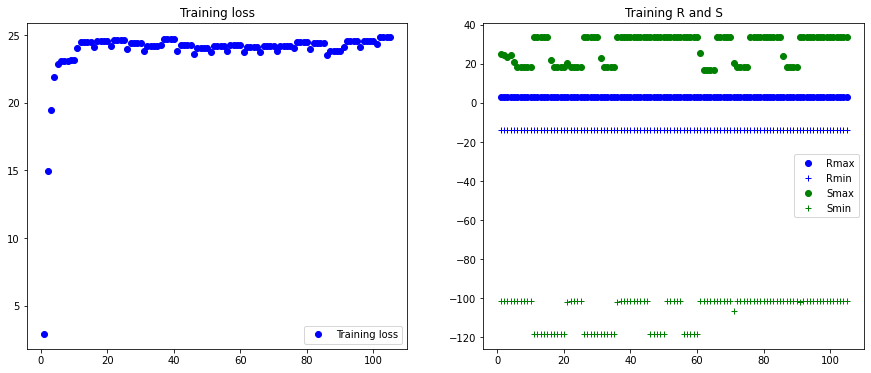

In [18]:
plotHistory(specProModel.history)

### Visualize resulting profiles as sequence logos

In [19]:
if False: # profiles after last report are just seeds
    ds_score = dsg.getDataset(genomes, tiles_per_X, tile_size).batch(batch_size).prefetch(3)
    printExpectedPatterns()
    P = specProModel.getP()
    #pScores = specProModel.max_profile_scores(ds_score)
    #plotLogo(P=P, idxarray = np.argsort(-pScores), pScores=pScores, max_print=20)
    pLosses = specProModel.min_profile_losses(ds_score)
    plotLogo(P=P, idxarray = np.argsort(pLosses), pScores=pLosses, max_print=5, label="loss")

Desired: ['MARIQSTANKE', 'WQEFNLLQIK', 'GKNSIYCK*R', 'FFICSRLNSCH', 'SLFAVD*ILA', 'LYLQ*IEFLP']
Repeat: ['REPEATAEPER', 'ENLKLLLNLK', 'RT*SYC*T*K', 'SFRFSSSFRFS', 'LSGSAVASGS', 'FQVQQ*LQVL']


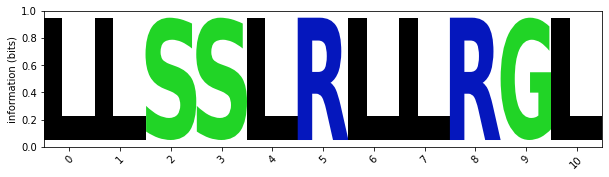

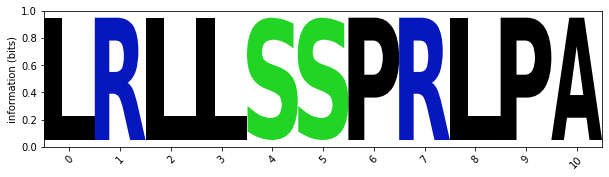

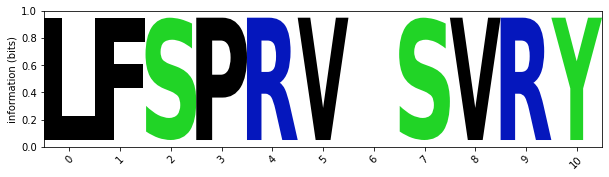

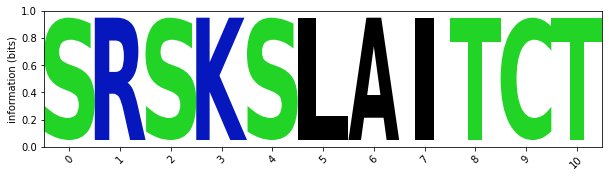

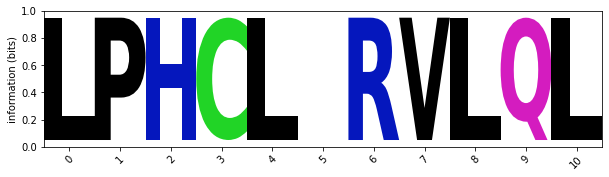

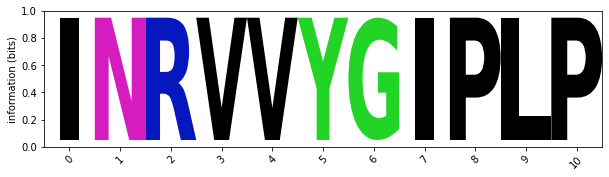

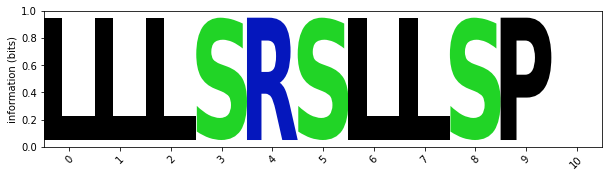

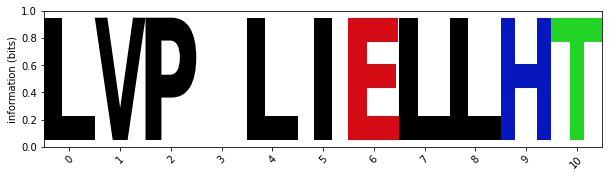

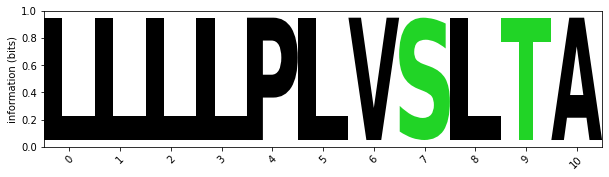

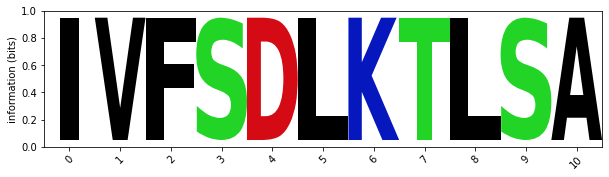

In [20]:
printExpectedPatterns()
plotLogo(P=specProModel.getP_report(), max_print=10, label="loss")

In [21]:
# STOP HERE IF `RUN ALL CELLS`
assert False

AssertionError: 

---

## Profile Score Distribution

In [ ]:
def customHist(distType: str, prec = 1):
    validDistTypes = ['score', 'loss', 'L5score']
    assert distType in validDistTypes, "distType must be one of "+str(validDistTypes)
    
    collect = {}
    ds_score = getDataset().batch(batch_size).prefetch(3)
    for batch in ds_score:
        for X in batch:
            S, _, _ = specProModel(X)
            if distType == 'score':
                for s in np.array(S).flatten():
                    score = np.math.floor(s*prec)
                    if score not in collect:
                        collect[score] = 0
                        
                    collect[score] += 1
                    
            if distType == 'loss':
                _, LpU, _ = specProModel.loss(S)
                for l in LpU:
                    loss = np.math.floor(l*prec)
                    if loss not in collect:
                        collect[loss] = 0
                        
                    collect[loss] += 1
                    
            if distType == 'L5score':
                gamma = .2
                S2 = tf.nn.softmax(gamma*S, axis=0)
                S3 = tf.math.multiply(S, tf.square(S2))
                for s in np.array(S3).flatten():
                    score = np.math.floor(s*prec)
                    if score not in collect:
                        collect[score] = 0
                        
                    collect[score] += 1
                    
    fkeys = [k for k in collect.keys()]
    bins = [b for b in range(min(fkeys), max(fkeys)+1)]
    vals = [collect[k] if k in collect else 0 for k in bins]
    bins = [b/prec for b in bins]
    
    plt.bar(list(range(len(bins))), vals, tick_label=[str(b) for b in bins])
    
    return bins, vals

In [ ]:
bins, vals = customHist('L5score', 0.5)

In [ ]:
bins, vals = customHist('loss', 100)

In [ ]:
bins, vals = customHist('score', 0.1)

     P:     (k, alphSize, U) 
     X:     (tilesPerX, N, 6, T, alphSize) 
     Z:     (tilesPerX, N, 6, T-k+1, U)
     S:     (tilesPerX, N, U)

In [ ]:
Scollect = []
Lcollect = []

if not use_real_data:
    ds_score = getDataset().batch(batch_size).prefetch(150)
    for batch in ds_score:
        for X in batch:
            S, _, Z = specProModel(X)
            _, LpU, _ = specProModel.loss(S)
            Scollect.extend(np.array(S).flatten())
            Lcollect.extend(np.array(LpU).flatten())

In [ ]:
plt.hist(Scollect)

In [ ]:
plt.hist(Lcollect)

In [ ]:
if not use_real_data:
    gamma = .01 # a small value means a more inclusive meaning of near-best
    S2 = tf.nn.softmax(gamma*S, axis=0)
    S3 = tf.reduce_max(S2, axis=0) # the closer to 1, the clearer is the champion match a winner
    S4 = tf.reduce_max(S, axis=0) # ranges over tiles, or soft max like in L1
    S5 = tf.math.multiply(S4, S3) # effectively the best score per genome is divided by the number of matches
    loss_by_unit = tf.reduce_sum(S5, axis=0) / U # sum over genomes
    L5 = tf.reduce_sum(loss_by_unit) # sum over profiles=units
    plt.hist(S4[:,0].numpy().flatten(), bins=20)
    S5.shape

---

### Profile Match Sites

In [28]:
# un-mask dataset
for g in range(len(genomes)):
    for c in range(len(genomes[g])):
        genomes[g][c] = genomes[g][c].upper()

In [39]:
tf.nn.softmax ( tf.math.log( specProModel.getP_report() ), axis=1 ) == specProModel.getP_report()

<tf.Tensor: shape=(11, 21, 20), dtype=bool, numpy=
array([[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],

       [[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],

       [[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  T

In [40]:
ds_sites = dsg.getDataset(genomes, tiles_per_X, tile_size, True).batch(batch_size).prefetch(3)
specProModel.setP_logit(tf.math.log(specProModel.getP_report())) # set reported P as profiles, otherwise get matches from randomly chosen seeds
sites = specProModel.get_profile_match_sites(ds_sites, 8.8)
sites

<tf.Tensor: shape=(23, 4), dtype=int32, numpy=
array([[     3,      2,  29103,      5],
       [     0,      2, 144976,      0],
       [     0,      2, 144976,     12],
       [     0,      4,  22272,     13],
       [     1,      6,    -24,     15],
       [     3,      8, 155565,     11],
       [     2,      8, 232075,     15],
       [     2,      8,  25029,     15],
       [     3,      8, 155561,      1],
       [     2,      8, 539961,      8],
       [     1,     10,    -23,     16],
       [     3,     18,  81311,     13],
       [     3,     22,  29103,      5],
       [     1,     26,    -24,     15],
       [     0,     22, 144976,      0],
       [     0,     22, 144976,     12],
       [     0,     24,  22272,     13],
       [     2,     28, 232075,     15],
       [     3,     28, 155565,     11],
       [     2,     28,  25029,     15],
       [     3,     28, 155561,      1],
       [     1,     30,    -23,     16],
       [     3,     38,  81311,     13]], dtype=int

In [41]:
import itertools

def sitesToLinks(sites):
    links = []
    profileToOcc = {}
    linkProfiles = set()
    for g, c, p, u in sites:
        if u not in profileToOcc:
            profileToOcc[u] = {}
            
        if g not in profileToOcc[u]:
            profileToOcc[u][g] = []
            
        profileToOcc[u][g].append([g,c,p])
        
    for p in profileToOcc:
        if (len(profileToOcc[p].keys()) == 1) or (0 not in profileToOcc[p]):
            continue
            
        occs = []
        for g in profileToOcc[p]:
            occs.append(profileToOcc[p][g])
            
        l = itertools.product(*occs)
        links.extend(l)
        linkProfiles.add(p)
    
    return links, linkProfiles

links, linkProfiles = sitesToLinks(sites.numpy())
print(links[:5])
print(linkProfiles)

[([0, 4, 22272], [3, 18, 81311]), ([0, 4, 22272], [3, 38, 81311]), ([0, 24, 22272], [3, 18, 81311]), ([0, 24, 22272], [3, 38, 81311])]
{13}


In [42]:
len(links)

4

In [43]:
print(insertTracking)

{0: {0: {'pos': [9467], 'pattern': ['ATGGCAAGAATTCAATCTACTGCAAATAAAGAA']}}, 1: {0: {'pos': [801], 'pattern': ['ATGGCAAGAATTCAATCTACTGCAAATAAAGAA']}}, 2: {0: {'pos': [267], 'pattern': ['ATGGCAAGAATTCAATCTACTGCAAATAAAGAA']}}, 3: {0: {'pos': [1004], 'pattern': ['ATGGCAAGAATTCAATCTACTGCAAATAAAGAA']}}, 4: {0: {'pos': [6239], 'pattern': ['ATGGCAAGAATTCAATCTACTGCAAATAAAGAA']}}, 5: {0: {'pos': [1286], 'pattern': ['ATGGCAAGAATTCAATCTACTGCAAATAAAGAA']}}, 6: {0: {'pos': [3064], 'pattern': ['ATGGCAAGAATTCAATCTACTGCAAATAAAGAA']}}, 7: {0: {'pos': [6319], 'pattern': ['ATGGCAAGAATTCAATCTACTGCAAATAAAGAA']}}}


#### Visualize Profile Matches

In [ ]:
maxplot = 4
nplot = 0
P = specProModel.getP()
for g in list(sites.keys()):
    for c in list(sites[g].keys()):
        gseq = genomes[g][c]
        for i in range(len(sites[g][c]['profile'])):
            p = sites[g][c]['profile'][i]
            pos = sites[g][c]['pos'][i]
            score = sites[g][c]['score'][i]
            f = sites[g][c]['frame'][i]
            
            match = gseq[pos:(pos+specProModel.k*3)+2]
            match_aa = su.six_frame_translation(match)
            profile_df = su.makeDFs(P[:,:,p:(p+1)].numpy())[0]
            logo = logomaker.Logo(profile_df, vpad=.1, width=1)
            logo.style_xticks(anchor=0, spacing=1, rotation=45)
            logo.ax.set_ylabel('information (bits)')
            logo.ax.set_title(f"Profile {p}" + (f" score={score:.1f}") + " | sequence match (frame "+str(f)+") "+', '.join(match_aa))
            
            nplot += 1
            if nplot >= maxplot:
                break
                
        if nplot >= maxplot:
            break
            
    if nplot >= maxplot:
        break

In [ ]:
_, _ = printExpectedPatterns()

#### "Sensitivity" of Profile Matches

In [45]:
def parseSequenceHeader(header):
    fields = header.split("|")
    headDict = {}
    for field in fields:
        key, value = field.split(":")
        assert len(field.split(":")) == 2, header
        assert key not in headDict, header
        headDict[key] = value

    return headDict

In [46]:
with open(os.path.join(datapath, "../hg38.GTF.json"), 'rt') as fh:
    gtf = json.load(fh)
    
gtf['ENST00000219797']

[{'seqname': '16',
  'source': 'ensembl',
  'feature': 'transcript',
  'start': 31117664,
  'end': 31131389,
  'score': '.',
  'strand': '+',
  'frame': '.',
  'attribute': 'gene_id "ENSG00000103510"; gene_version "19"; transcript_id "ENST00000219797"; transcript_version "8"; gene_name "KAT8"; gene_source "ensembl_havana"; gene_biotype "protein_coding"; transcript_name "KAT8-201"; transcript_source "ensembl"; transcript_biotype "protein_coding"; tag "CCDS"; ccds_id "CCDS10706"; tag "basic"; transcript_support_level "1";\n',
  'rstart': 11341,
  'rend': 25066,
  'tag': 'ENST00000219797_f0'},
 {'seqname': '16',
  'source': 'ensembl',
  'feature': 'exon',
  'start': 31117664,
  'end': 31117892,
  'score': '.',
  'strand': '+',
  'frame': '.',
  'attribute': 'gene_id "ENSG00000103510"; gene_version "19"; transcript_id "ENST00000219797"; transcript_version "8"; exon_number "1"; gene_name "KAT8"; gene_source "ensembl_havana"; gene_biotype "protein_coding"; transcript_name "KAT8-201"; transcr

In [47]:
with open(os.path.join(datapath, "../orthologs.json"), 'rt') as fh:
    orthology = json.load(fh)
    
orthology

{'genome:mm10|seqstart:39978843|seqend:42188407|seqlen:2209565|genestart:39984361|geneend:42181679|rgenestart:5518|rgeneend:2202836|genelen:2197319|chrlen:98207768|chr:chr16|strand:+|gid:ENSMUSG00000061080|tid:ENSMUSG00000061080': ['genome:hetGla2|seqstart:31863942|seqend:32551568|seqlen:687627|genestart:31872494|geneend:32542316|rgenestart:8552|rgeneend:678374|genelen:669823|chrlen:46765855|chr:JH602044|strand:+|gid:ENSHGLG00000013507|tid:ENSHGLG00000013507',
  'genome:macFas5|seqstart:155767571|seqend:156457534|seqlen:689964|genestart:155777451|geneend:156447984|rgenestart:9880|rgeneend:680413|genelen:670534|chrlen:192460366|chr:chr2|strand:+|gid:ENSMFAG00000037703|tid:ENSMFAG00000037703',
  'genome:hg38|seqstart:115796660|seqend:117145532|seqlen:1348873|genestart:115802363|geneend:117139389|rgenestart:6143|rgeneend:1343169|genelen:1337027|chrlen:198295559|chr:chr3|strand:-|gid:ENSG00000185565|tid:ENST00000490035'],
 'genome:macFas5|seqstart:100300678|seqend:100651143|seqlen:350466|g

In [48]:
seqnames[0][0:2]

['genome:hg38|seqstart:71618403|seqend:71650828|seqlen:32426|genestart:71626161|geneend:71642114|rgenestart:7758|rgeneend:23711|genelen:15954|chrlen:90338345|chr:chr16|strand:+|gid:ENSG00000140832|tid:ENST00000268485',
 'genome:hg38|seqstart:0|seqend:32425|seqlen:32426|genestart:0|geneend:32425|rgenestart:0|rgeneend:32425|genelen:32426|chrlen:32426|chr:0|strand:+|gid:artificial|tid:140']

In [49]:
nexons = 0
northo = 0
for seq in seqnames[0]:
    seqDict = parseSequenceHeader(seq)
    if seqDict['tid'] != 'artificial':
        northo += 1
    if seqDict['tid'] in gtf:
        nexons += len([1 for annot in gtf[seqDict['tid']] if annot['feature'] == 'CDS'])
        
print(nexons)
print(northo)

328
40


In [51]:
links[0]

([0, 4, 22272], [3, 18, 81311])

In [52]:
tolerance = 3*k + 3 # allow certain position mismatch in human exons
tp = [] # accumulate scores
fp = []
noise = []
geneNoise = []
exonsFound = set()
featuresFound = set()
orthoFound = set()
for link in links:
    allArt = True
    allGen = True
    for occ in link:
        #print("DEBUG", occ)
        seqname = seqnames[occ[0]][occ[1]]
        seqDict = parseSequenceHeader(seqname)
        if seqDict['gid'] == 'artificial':
            allGen = False
        else:
            allArt = False
            
    mscore = 0#np.mean([o[3] for o in link])
    if allArt:
        fp.append(mscore)
    elif not (allArt or allGen):
        noise.append(mscore)
    else:
        assert allGen
        rSeq = seqnames[link[0][0]][link[0][1]]
        assert rSeq in orthology, rSeq
        if all([seqnames[o[0]][o[1]] in orthology[rSeq] for o in link[1:]]):
            tp.append(mscore)
            orthoFound.add(rSeq)
            seqDict = parseSequenceHeader(rSeq)
            tid = seqDict['tid']
            pos = link[0][2]
            if tid in gtf:
                for feature in gtf[tid]:
                    if feature['rstart']-tolerance <= pos and pos <= feature['rend']+tolerance:
                        featuresFound.add(str(feature))
                        if feature['feature'] == 'CDS':
                            exonsFound.add(feature['tag'])
                    else:
                        print("[DEBUG]", pos, "not in", feature['rstart'], feature['rend'], "(", feature['feature'],")")
        else:
            geneNoise.append(mscore)

In [53]:
print("TP:", len(tp), "| mean score:", sum(tp)/len(tp) if len(tp) > 0 else 0)
print("FP:", len(fp), "| mean score:", sum(fp)/len(fp) if len(fp) > 0 else 0)
print("noise:", len(noise), "| mean score:", sum(noise)/len(noise) if len(noise) > 0 else 0)
print("geneNoise:", len(geneNoise), "| mean score:", sum(geneNoise)/len(geneNoise) if len(geneNoise) > 0 else 0)

print("Sn:", len(exonsFound), "/", nexons, "=", len(exonsFound)/nexons)
print("hits:", len(orthoFound), "/", northo, "=", len(orthoFound)/northo)

TP: 0 | mean score: 0
FP: 0 | mean score: 0
noise: 0 | mean score: 0
geneNoise: 4 | mean score: 0.0
Sn: 0 / 328 = 0.0
hits: 0 / 40 = 0.0


In [54]:
for f in featuresFound:
    print(f)

In [ ]:
import plotly.graph_objects as go

In [ ]:
fig = go.Figure()
fig.add_trace(go.Histogram(x=tp, name="TP", histnorm='probability'))
fig.add_trace(go.Histogram(x=fp, name="FP", histnorm='probability'))
fig.add_trace(go.Histogram(x=noise, name="noise", histnorm='probability'))
fig.add_trace(go.Histogram(x=geneNoise, name="geneNoise", histnorm='probability'))

# Overlay both histograms and reduce opacity to see both histograms
#fig.update_layout(barmode='overlay')
#fig.update_traces(opacity=0.75)
fig.show()

In [ ]:
assert False # stop here

In [ ]:
Q

In [ ]:
str(P[:,:,0][0].numpy())

In [ ]:
def profileToMEME(p, Q, i):
    assert p.shape[1] == len(Q), str(p.shape)+", "+str(len(Q))
    assert p.shape[1] == len(su.aa_alphabet[1:]), str(p.shape)+", "+str(len(su.aa_alphabet[1:]))
    
    text = 'MEME version 4\n'
    text += 'ALPHABET "extProtein" PROTEIN-LIKE\n'
    for aa in su.aa_alphabet[1:]:
        text += aa+"\n"
        
    text += 'END ALPHABET\n'
    text += "Background letter frequencies\n"
    freq = " ".join([su.aa_alphabet[i+1]+" "+str(Q[i]) for i in range(len(Q))])
    text += freq+"\n"
    text += "MOTIF "+str(i)+" "+str(i)+"\n"
    text += "letter-probability matrix: alength= "+str(p.shape[1])+" w= "+str(p.shape[0])+"\n"
    


    AC  MA0001.1
    XX
    ID  AGL3
    XX
    DE  MA0001.1 AGL3; from JASPAR
    PO       A     C     G     T
    1        0    94     1     2
    2        3    75     0    19
    3       79     4     3    11
    4       40     3     4    50
    5       66     1     1    29
    6       48     2     0    47
    7       65     5     5    22
    8       11     2     3    81
    9       65     3    28     1
    10       0     3    88     6
    XX
    CC  program: jaspar
    XX
    //

In [ ]:
def profileToTransfac(p, i):
    assert p.shape[1] == len(su.aa_alphabet[1:]), str(p.shape)+", "+str(len(su.aa_alphabet[1:]))
    text = "AC  "+str(i)+"\n"
    text += "XX\n"
    text += "ID  "+str(i)+"\n"
    text += "XX\n"
    text += "DE  "+str(i)+"\n"
    text += "PO  "+(" ".join([su.aa_alphabet[i+1] for i in range(len(Q))]))+"\n"
    for i in range(p.shape[0]):
        text += str(i+1)+"  "+(" ".join(str(v) for v in p.numpy()[i]))+"\n"
        
    text += "XX\n"
    text += "CC  program: own\n"
    text += "//"
    return text

In [ ]:
print(profileToTransfac(P[:,:,0], 0))

In [ ]:
with open("/nas-hs/users/matthis/genomegraph/testProfileTransfacOutput.txt", 'wt') as fh:
    for i in range(P.shape[2]):
        fh.write(profileToTransfac(P[:,:,i], i))

In [ ]:
def cosineSim(a: np.ndarray, b: np.ndarray):
    assert len(a) == len(b)
    return np.sum(a*b) / (np.sqrt(np.sum(np.square(a))) * np.sqrt(np.sum(np.square(b))))

In [ ]:
cosineSim(np.array([0,1,0,0]), np.array([1,0,0,0]))

In [ ]:
# modified version of https://gist.github.com/nornagon/6326a643fc30339ece3021013ed9b48c
# enforce gapless alignment
def smith_waterman(a, b) -> float:
    assert a.shape[1] == b.shape[1], str(a.shape)+", "+str(b.shape)
    # H holds the alignment score at each point, computed incrementally
    H = np.zeros((a.shape[0] + 1, b.shape[0] + 1))
    for i in range(1, a.shape[0] + 1):
        for j in range(1, b.shape[0] + 1):
            # The score for substituting the letter a[i-1] for b[j-1]. Generally low
            # for mismatch, high for match.
            H[i,j] = H[i-1,j-1] + cosineSim(a[i-1], b[j-1])
    # The highest score is the best local alignment.
    # For our purposes, we don't actually care _what_ the alignment was, just how
    # aligned the two strings were.
    return H.max()

In [ ]:
def profileLogo(i, title="", P=P):
    profile_df = su.makeDFs(P[:,:,i:(i+1)].numpy())[0]
    logo = logomaker.Logo(profile_df, vpad=.1, width=1)
    logo.style_xticks(anchor=0, spacing=1, rotation=45)
    logo.ax.set_ylabel('information (bits)')
    logo.ax.set_title(title)

In [ ]:
a = P[:,:,0]
profileLogo(0, "Reference profile")

for i in range(5653,5658):
    b = P[:,:,i]
    s = smith_waterman(a,b)
    profileLogo(i, "Aligning with score "+str(s))

In [ ]:
for i in range(P.shape[2]):
    for j in range(i+1, P.shape[2]):
        if smith_waterman(P[:,:,i], P[:,:,j]) >= P.shape[0]/2:
            print("Similar:",i,"and",j)
            profileLogo(i,str(i))
            profileLogo(j,str(j))

---

## Find Best Profiles

Idea: 
* convert profiles into aa-sequences (translate max. values into aa at each position)
* align (or perfect match?) sequences against the 6 possible pattern translations and the insert translations
* alignment scores give an idea of how good the profiles are -> allows multiple training runs to account for randomness, evaluate how good the profiles usually are (+ variance)

In [ ]:
from Bio import pairwise2
from Bio.pairwise2 import format_alignment

In [ ]:
def runTraining():
    tf.keras.backend.clear_session() # avoid memory cluttering by remains of old models
    
    # build and randomly initialize profile model
    specProModel = SpecificProfile(k, su.aa_alphabet_size, U, Q)
    
    #start = time()
    specProModel.train_ds(ds, steps_per_epoch, epochs=500, verbose=False)
    #end = time()
    #print(f"time: {end-start:.2f}")
    
    #S, R = specProModel(X)
    #_, (L1, L2, L4, L7) = specProModel.loss(S)
    #pScores = tf.reduce_sum(tf.reduce_max(S,axis=0), axis=0).numpy()
    #print("pScores", pScores)
    #np.argsort(pScores)
    #print ("loss=", L1.numpy(), "\tL2=", L2.numpy(), 
    #       "\tL4=", L4.numpy(), "\nS=", S.numpy())
    
    P = specProModel.getP()
    
    return P

In [ ]:
def aaFromProfiles(P):
    profiles_aa = []
    for pidx in range(P.shape[2]):
        pmat = P[:,:,pidx]
        profiles_aa.append(su.to_aa_seq(pmat))

    return profiles_aa

In [ ]:
def getBestAlignments(profiles, patterns, scoreThreshold = int(k/2)):
    scores = []
    alignments = []
    best_profiles = []
    for profile in profiles:
        pscores = []
        palignments = []
        for pattern in patterns:
            als = pairwise2.align.localxd(profile, pattern, openA=-1000, extendA=-1000, openB=-1000, extendB=-1000)
            s = [al.score for al in als]
            if len(s) > 0:
                pscores.append(np.argmax(s))
                palignments.append(als[np.argmax(s)])

        best_al = palignments[np.argmax(pscores)]
        if best_al.score >= scoreThreshold:
            scores.append(best_al.score)
            alignments.append(best_al)
            best_profiles.append(profile)

    if len(scores) > 0:
        sortedIdx = np.argsort([-s for s in scores])
        scores = [scores[i] for i in sortedIdx]
        alignments = [alignments[i] for i in sortedIdx]
        best_profiles = [best_profiles[i] for i in sortedIdx]
    
    return scores, alignments, best_profiles

In [ ]:
if False:
    for i in range(20):
        P = runTraining()
        profiles = aaFromProfiles(P)
        print("Run", i)
        if insertPatterns is not None:
            print("Desired profiles:")
            patternScores, patternAlignments, patternProfiles = getBestAlignments(profiles, desiredPatternAA)
            for i in range(len(patternScores)):
                    print(patternProfiles[i])
                    print(format_alignment(*(patternAlignments[i])))

        if repeatPatterns is not None:
            print("Undesired profiles:")
            repeatScores, repeatAlignments, repeatProfiles = getBestAlignments(profiles, repeatPatternAA)
            for i in range(len(repeatScores)):
                    print(repeatProfiles[i])
                    print(format_alignment(*(repeatAlignments[i])))

        print("")
        print("-----")
        print("")
        
else:
    P = specProModel.getP()
    profiles = aaFromProfiles(P)

    if insertPatterns is not None:
        print("Desired profiles:")
        patternScores, patternAlignments, patternProfiles = getBestAlignments(profiles, desiredPatternAA, scoreThreshold=4)
        for i in range(len(patternScores)):
                print(patternProfiles[i])
                print(format_alignment(*(patternAlignments[i])))

    if repeatPatterns is not None:
        print("Undesired profiles:")
        repeatScores, repeatAlignments, repeatProfiles = getBestAlignments(profiles, repeatPatternAA, scoreThreshold=4)
        for i in range(len(repeatScores)):
            print(repeatProfiles[i])
            print(format_alignment(*(repeatAlignments[i])))

In [ ]:
R = specProModel.getR()
profiles = aaFromProfiles(R)
if insertPatterns is not None:
    print("Desired profiles:")
    patternScores, patternAlignments, patternProfiles = getBestAlignments(profiles, desiredPatternAA, scoreThreshold=4)
    for i in range(len(patternScores)):
            print(patternProfiles[i])
            print(format_alignment(*(patternAlignments[i])))

if repeatPatterns is not None:
    print("Undesired profiles:")
    repeatScores, repeatAlignments, repeatProfiles = getBestAlignments(profiles, repeatPatternAA, scoreThreshold=4)
    for i in range(len(repeatScores)):
        print(repeatProfiles[i])
        print(format_alignment(*(repeatAlignments[i])))

---

### Evaluate Parameter Grid

In [ ]:
from datetime import time, datetime
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px

In [ ]:
dfN = pd.read_csv("20211111_evaluate_gensize_N.csv")
dfGS = pd.read_csv("20211111_evaluate_gensize_GS.csv")
dfNS = pd.read_csv("20211111_evaluate_gensize_NS.csv")
print(dfN)
print(dfGS)
print(dfNS)

In [ ]:
def timeFromStr(tstr: str):
    h,m,s = tstr.split(":")
    s, us = s.split(".")
    us = float("0."+us) * 1000000
    #print(h,m,s,us)
    return time(int(h),int(m),int(s), int(us))

def secondsFromStr(tstr: str):
    h,m,s = tstr.split(":")
    seconds = (int(h)*60*60) + (int(m)*60) + float(s)
    return seconds
    
runtime = [secondsFromStr(s) for s in df['runtime']]

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['U'], y=runtime, name="runtime"))
fig.update_xaxes(title_text='U')
fig.update_yaxes(title_text='runtime [s]')#, type='log')
fig.show()


fig = go.Figure()
fig.add_trace(go.Scatter(x=df['U'], y=df['memory'], name="memory [MB]"))
fig.update_xaxes(title_text='U')
fig.update_yaxes(title_text='Memory [MB]')
fig.show()

In [ ]:
gsN = []
for _, row in dfN.iterrows():
    gsN.append(int(row['N']) * int(row['genome-sizes']))
    
gsGS = []
for _, row in dfGS.iterrows():
    gsGS.append(int(row['N']) * int(row['genome-sizes']))
    
gsNS = []
for _, row in dfNS.iterrows():
    gs = [int(s) for s in row['genome-sizes'].split()]
    gsNS.append(int(row['N']) * sum(gs))

fig = go.Figure()
fig.add_trace(go.Scatter(x=gsN, y=[secondsFromStr(s) for s in dfN['runtime']], name="runtime N"))
fig.add_trace(go.Scatter(x=gsGS, y=[secondsFromStr(s) for s in dfGS['runtime']], name="runtime GS"))
fig.add_trace(go.Scatter(x=gsNS, y=[secondsFromStr(s) for s in dfNS['runtime']], name="runtime NS"))
fig.update_xaxes(title_text='genome size')
fig.update_yaxes(title_text='runtime [s]')
fig.show()


fig = go.Figure()
fig.add_trace(go.Scatter(x=gsN, y=dfN['memory'], name="memory [MB] N"))
fig.add_trace(go.Scatter(x=gsGS, y=dfGS['memory'], name="memory [MB] GS"))
fig.add_trace(go.Scatter(x=gsNS, y=dfNS['memory'], name="memory [MB] NS"))
fig.update_xaxes(title_text='genome size')
fig.update_yaxes(title_text='Memory [MB]')
fig.show()

In [ ]:
x = []
yr = []
ym = []
for _, row in dfN.iterrows():
    x.append(int(row['N']))
    yr.append(secondsFromStr(row['runtime']))
    ym.append(float(row['memory']))
    
fig = go.Figure()
fig.add_trace(go.Scatter(x=x, y=yr, name="runtime"))
fig.update_xaxes(title_text='genome size')
fig.update_yaxes(title_text='runtime [s]')
fig.show()


fig = go.Figure()
fig.add_trace(go.Scatter(x=x, y=ym, name="memory [MB] N"))
fig.update_xaxes(title_text='genome size')
fig.update_yaxes(title_text='Memory [MB]')
fig.show()

In [ ]:
x = []
yr = []
ym = []
for _, row in dfGS.iterrows():
    x.append(int(row['genome-sizes']))
    yr.append(secondsFromStr(row['runtime']))
    ym.append(float(row['memory']))
    
fig = go.Figure()
fig.add_trace(go.Scatter(x=x, y=yr, name="runtime"))
fig.update_xaxes(title_text='genome size')
fig.update_yaxes(title_text='runtime [s]')
fig.show()


fig = go.Figure()
fig.add_trace(go.Scatter(x=x, y=ym, name="memory [MB] N"))
fig.update_xaxes(title_text='genome size')
fig.update_yaxes(title_text='Memory [MB]')
fig.show()

In [ ]:
x = []
yr = []
ym = []
for _, row in dfNS.iterrows():
    x.append(sum([int(s) for s in row['genome-sizes'].split()]))
    yr.append(secondsFromStr(row['runtime']))
    ym.append(float(row['memory']))
    
fig = go.Figure()
fig.add_trace(go.Scatter(x=x, y=yr, name="runtime"))
fig.update_xaxes(title_text='genome size')
fig.update_yaxes(title_text='runtime [s]')
fig.show()


fig = go.Figure()
fig.add_trace(go.Scatter(x=x, y=ym, name="memory [MB] N"))
fig.update_xaxes(title_text='genome size')
fig.update_yaxes(title_text='Memory [MB]')
fig.show()